In [1]:
import os, sys, numpy as np, time, random
import matplotlib.pyplot as plt

# Set up the source path (adjust as needed for your project structure)
notebooks_path = os.path.abspath(os.getcwd())
src_path = os.path.abspath(os.path.join(notebooks_path, "../src"))
if src_path not in sys.path:
    sys.path.insert(0, src_path)

# Import custom functions for adapted measures, solvers, and tree visualization
from optimal_code.utils import *
from optimal_code.optimal_solver import *
from trees.build_trees_from_paths import *
from trees.treeVisualization import *
from adapted_empirical_measure.AEM_grid import *

## I am really note sure about this one still close to Markovian only

In [ ]:
# ----------------------------------------------------------------------------
# Define a GARCH(2,1) simulation function (non-Markovian)
# ----------------------------------------------------------------------------
def garch21_simulation(n_sample, T, mu, omega, alpha1, alpha2, beta, seed):
    """
    Simulates an asset price process under a GARCH(2,1) model.
    
    The returns are given by:
        r_t = mu + sigma_{t-1} * Z_t,   with Z_t ~ N(0,1),
    and the asset price is updated as:
        X_t = X_{t-1} * exp(r_t).
    
    The volatility evolves as:
        sigma_t = sqrt(omega + alpha1 * epsilon_{t-1}^2 + alpha2 * epsilon_{t-2}^2 + beta * sigma_{t-1}^2),
    with the innovation
        epsilon_t = sigma_{t-1} * Z_t.
    
    For t=1 the term epsilon_{t-2} is set to 0.
    
    Parameters:
      n_sample: int
          Number of sample paths.
      T: int
          Total number of time steps (the returned array has shape (T+1, n_sample)).
      mu: float
          Drift term in the return equation.
      omega: float
          Constant term in the variance equation.
      alpha1: float
          Coefficient on the lagged squared innovation at t-1.
      alpha2: float
          Coefficient on the lagged squared innovation at t-2.
      beta: float
          Coefficient on the lagged volatility.
      seed: int
          Random seed.
    
    Returns:
      X: np.ndarray of shape (T+1, n_sample)
         Simulated asset price paths.
    """
    np.random.seed(seed)
    X = np.zeros((T+1, n_sample))
    sigma_t = np.zeros((T+1, n_sample))
    epsilon = np.zeros((T+1, n_sample))
    
    # Initialize asset prices and volatility.
    X[0, :] = 1.0
    # For stationarity (if alpha1+alpha2+beta < 1), set initial volatility to the unconditional level.
    if (alpha1 + alpha2 + beta) < 1:
        sigma0 = np.sqrt(omega / (1 - (alpha1 + alpha2 + beta)))
    else:
        sigma0 = 1.0
    sigma_t[0, :] = sigma0
    epsilon[0, :] = 0.0
    
    for t in range(1, T+1):
        Z = np.random.normal(loc=0.0, scale=1.0, size=n_sample)
        # Compute return using the previous period's volatility.
        r_t = mu + sigma_t[t-1, :] * Z
        X[t, :] = X[t-1, :] * np.exp(r_t)
        # Innovation at time t.
        epsilon[t, :] = sigma_t[t-1, :] * Z
        # Volatility update: for t==1, use epsilon[t-1] and set epsilon[t-2]=0.
        if t == 1:
            sigma_t[t, :] = np.sqrt(omega + alpha1 * (epsilon[t-1, :]**2) + alpha2 * (0.0) + beta * (sigma_t[t-1, :]**2))
        else:
            sigma_t[t, :] = np.sqrt(omega + alpha1 * (epsilon[t-1, :]**2) + alpha2 * (epsilon[t-2, :]**2) + beta * (sigma_t[t-1, :]**2)) 
    return X ## the above line is the small non markvian part

In [6]:
# ----------------------------------------------------------------------------
# Experiment Parameters
# ----------------------------------------------------------------------------
T = 10  # Total time steps

# Parameters for Process X (less volatile)
mu_x     = 0.0001
# Choose parameters such that alpha1 + alpha2 + beta < 1
omega_x  = 1.2e-5   # roughly calibrated so that the unconditional volatility is low (~1%)
alpha1_x = 0.05
alpha2_x = 0.03
beta_x   = 0.80

# Parameters for Process Y (more volatile)
mu_y     = 0.0001
omega_y  = 6e-5     # higher omega leads to a higher unconditional variance (~2%)
alpha1_y = 0.10
alpha2_y = 0.05
beta_y   = 0.70

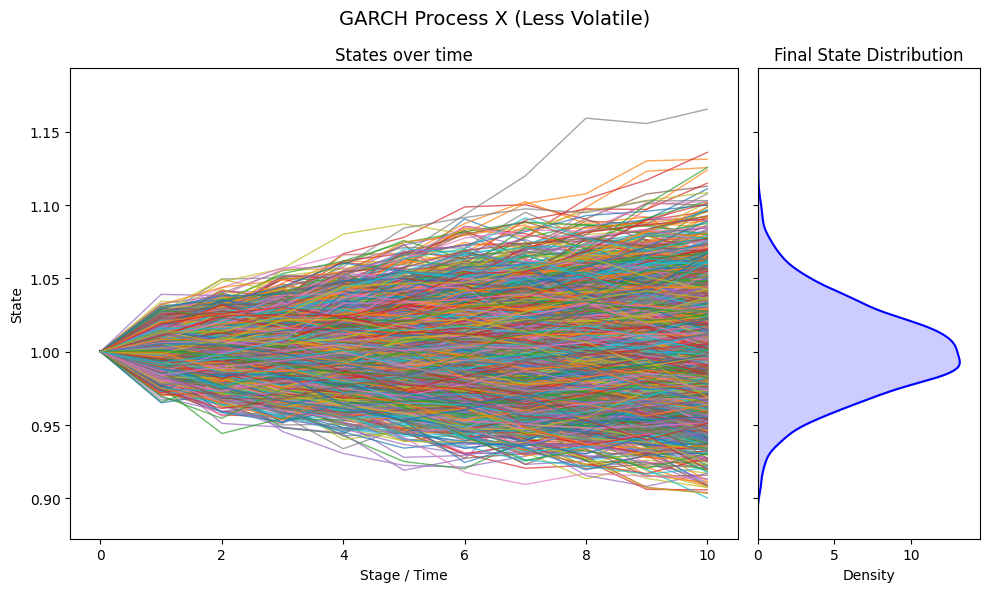

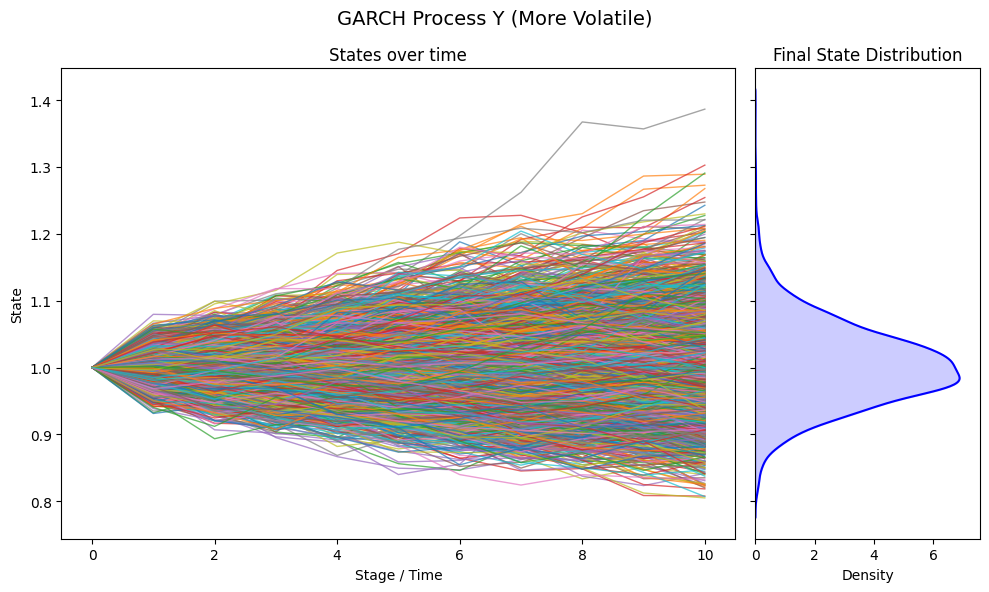

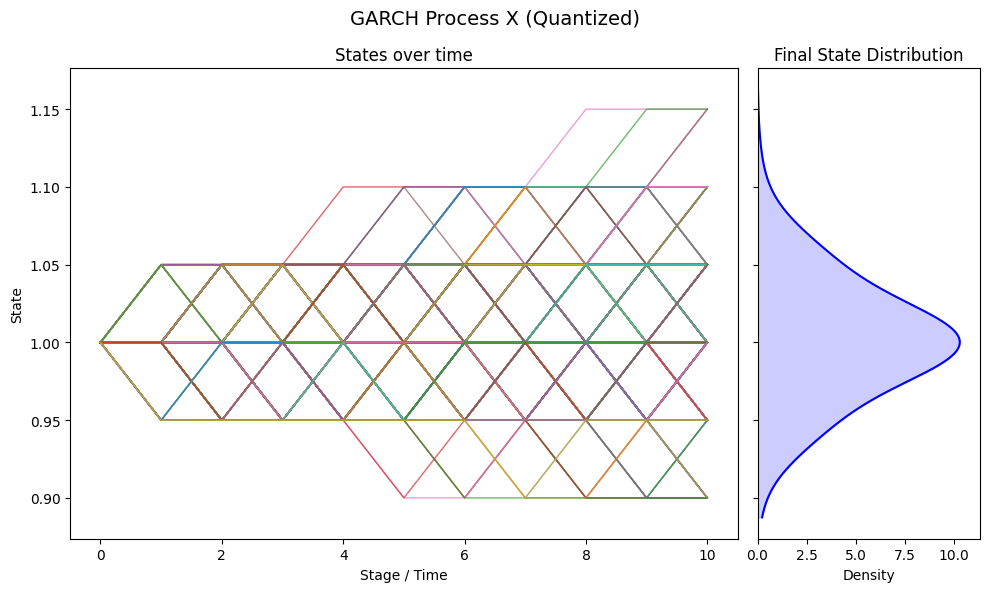

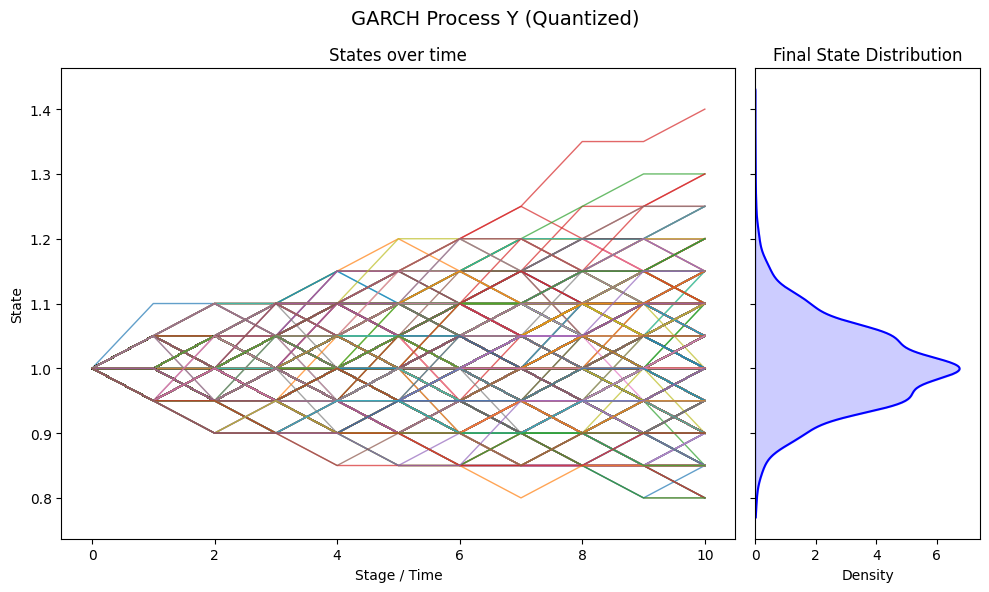

In [8]:
# ----------------------------------------------------------------------------
# Visualize Trees for a Fixed Sample (for quick inspection)
# ----------------------------------------------------------------------------
n_sample = 5000
seed = 44

# Simulate the GARCH(2,1) processes for visualization
X = garch21_simulation(n_sample, T, mu_x, omega_x, alpha1_x, alpha2_x, beta_x, seed)
Y = garch21_simulation(n_sample, T, mu_y, omega_y, alpha1_y, alpha2_y, beta_y, seed)

iid_weights = np.full(n_sample, 1 / n_sample)

# Build and visualize the tree for Process X
root = build_tree_from_paths(X.T, iid_weights)
visualize_big_tree(
    root,
    fig_size=(10, 6),
    title="GARCH Process X (Less Volatile)",
)

# Build and visualize the tree for Process Y
root = build_tree_from_paths(Y.T, iid_weights)
visualize_big_tree(
    root,
    fig_size=(10, 6),
    title="GARCH Process Y (More Volatile)",
)

# Apply grid quantization (using a coarse grid for visualization)
fixed_grid = 0.05

new_sample_paths, new_weights = uniform_empirical_grid_measure(X.T, fixed_grid, use_weights=True)
root = build_tree_from_paths(new_sample_paths, new_weights)
visualize_big_tree(
    root,
    fig_size=(10, 6),
    title="GARCH Process X (Quantized)",
)

new_sample_paths, new_weights = uniform_empirical_grid_measure(Y.T, fixed_grid, use_weights=True)
root = build_tree_from_paths(new_sample_paths, new_weights)
visualize_big_tree(
    root,
    fig_size=(10, 6),
    title="GARCH Process Y (Quantized)",
)

In [9]:
# ----------------------------------------------------------------------------
# Running Experiments: Compute Adapted Wasserstein Distance vs. Sample Size
# ----------------------------------------------------------------------------
sample_sizes = [500, 1000, 3000, 5000, 7500]  # Sample sizes for experiments
n_runs = 10  # Number of independent runs per sample size

results = {}

for n_sample in sample_sizes:
    distances_runs = np.zeros(n_runs)
    times_runs = np.zeros(n_runs)
    
    print(f"\nRunning experiments for sample size: {n_sample}")
    for run in range(n_runs):
        # New random seed for each run
        seed = np.random.randint(10000)
        
        # Simulate GARCH(2,1) paths for both processes with the same seed
        X = garch21_simulation(n_sample, T, mu_x, omega_x, alpha1_x, alpha2_x, beta_x, seed)
        Y = garch21_simulation(n_sample, T, mu_y, omega_y, alpha1_y, alpha2_y, beta_y, seed)
        
        # Convert raw paths to adapted paths using grid quantization
        adaptedX = path2adaptedpath(X, delta_n=fixed_grid)
        adaptedY = path2adaptedpath(Y, delta_n=fixed_grid)
        
        # Build quantization mapping from the union of grid values
        q2v = np.unique(np.concatenate([adaptedX, adaptedY], axis=0))
        v2q = {k: v for v, k in enumerate(q2v)}
        qX = np.array([[v2q[x] for x in y] for y in adaptedX])
        qY = np.array([[v2q[x] for x in y] for y in adaptedY])
        # Ensure proper ordering: transpose so that shape becomes (n_sample, T+1)
        qX = sort_qpath(qX.T)
        qY = sort_qpath(qY.T)
        
        # Obtain the conditional measures (non-Markovian)
        mu_x_measure = qpath2mu_x(qX)
        nu_y_measure = qpath2mu_x(qY)
        
        # Represent these measures as lists for the nested solver
        mu_x_c, mu_x_cn, mu_x_v, mu_x_w, mu_x_cumn = list_repr_mu_x(mu_x_measure, q2v)
        nu_y_c, nu_y_cn, nu_y_v, nu_y_w, nu_y_cumn = list_repr_mu_x(nu_y_measure, q2v)
        
        # Compute the adapted Wasserstein squared distance using the non-Markovian parallel solver
        t_start = time.perf_counter()
        AW_2square = nested2_parallel(mu_x_cn, mu_x_v, mu_x_w, mu_x_cumn,
                                      nu_y_cn, nu_y_v, nu_y_w, nu_y_cumn,
                                      n_processes=30)
        elapsed = time.perf_counter() - t_start
        
        distances_runs[run] = AW_2square
        times_runs[run] = elapsed
        
        print(f"Sample size {n_sample}, Run {run+1}: AW_2^2 = {AW_2square:.4f}, Time = {elapsed:.4f} s")
    
    results[n_sample] = {"distances": distances_runs, "times": times_runs}


Running experiments for sample size: 500


100%|███████████████████████████████████████████| 4/4 [00:00<00:00, 1107.48it/s]

100%|████████████████████████████████████████████| 4/4 [00:00<00:00, 453.68it/s]


100%|███████████████████████████████████████████| 3/3 [00:00<00:00, 1081.01it/s]

100%|████████████████████████████████████████████| 3/3 [00:00<00:00, 505.11it/s]



100%|████████████████████████████████████████████| 3/3 [00:00<00:00, 507.78it/s]

100%|████████████████████████████████████████████| 3/3 [00:00<00:00, 882.89it/s]

100%|████████████████████████████████████████████| 3/3 [00:00<00:00, 515.52it/s]

100%|████████████████████████████████████████████| 3/3 [00:00<00:00, 356.65it/s]

100%|████████████████████████████████████████████| 2/2 [00:00<00:00, 835.52it/s]

100%|███████████████████████████████████████████| 2/2 [00:00<00:00, 1063.87it/s]

  0%|                                                     | 0/2 [00:00<?, ?it/s]


100%|████████████████████████████████████████████| 2/2 [00:00<00:00, 318.16it/s]

100%|███████

Sample size 500, Run 1: AW_2^2 = 0.0186, Time = 2.6769 s


  0%|                                                     | 0/4 [00:00<?, ?it/s]

100%|███████████████████████████████████████████| 4/4 [00:00<00:00, 1060.77it/s]

100%|████████████████████████████████████████████| 4/4 [00:00<00:00, 650.66it/s]




100%|███████████████████████████████████████████| 4/4 [00:00<00:00, 1054.77it/s]


100%|███████████████████████████████████████████| 4/4 [00:00<00:00, 1021.44it/s]

100%|████████████████████████████████████████████| 4/4 [00:00<00:00, 251.57it/s]

100%|████████████████████████████████████████████| 3/3 [00:00<00:00, 901.55it/s]

100%|████████████████████████████████████████████| 3/3 [00:00<00:00, 509.72it/s]


100%|████████████████████████████████████████████| 3/3 [00:00<00:00, 240.18it/s]

100%|████████████████████████████████████████████| 3/3 [00:00<00:00, 292.14it/s]



100%|████████████████████████████████████████████| 2/2 [00:00<00:00, 385.93it/s]

100%|███████████████████████████████████████████| 2/2 [00:00<00:00, 1060.64it/s]


100%|███

Sample size 500, Run 2: AW_2^2 = 0.0200, Time = 2.6739 s


100%|███████████████████████████████████████████| 4/4 [00:00<00:00, 1144.50it/s]


100%|████████████████████████████████████████████| 4/4 [00:00<00:00, 590.71it/s]

100%|████████████████████████████████████████████| 4/4 [00:00<00:00, 560.59it/s]

100%|███████████████████████████████████████████| 4/4 [00:00<00:00, 1164.11it/s]

100%|███████████████████████████████████████████| 4/4 [00:00<00:00, 1168.33it/s]

100%|████████████████████████████████████████████| 4/4 [00:00<00:00, 329.21it/s]

100%|████████████████████████████████████████████| 4/4 [00:00<00:00, 935.65it/s]

  0%|                                                     | 0/3 [00:00<?, ?it/s]

100%|████████████████████████████████████████████| 3/3 [00:00<00:00, 557.75it/s]

100%|████████████████████████████████████████████| 3/3 [00:00<00:00, 905.90it/s]

100%|████████████████████████████████████████████| 3/3 [00:00<00:00, 548.92it/s]

100%|████████████████████████████████████████████| 3/3 [00:00<00:00, 559.79it/s]

100%|██████████

Sample size 500, Run 3: AW_2^2 = 0.0176, Time = 2.6084 s


100%|████████████████████████████████████████████| 5/5 [00:00<00:00, 526.64it/s]

100%|████████████████████████████████████████████| 4/4 [00:00<00:00, 455.02it/s]

100%|████████████████████████████████████████████| 4/4 [00:00<00:00, 360.85it/s]

100%|████████████████████████████████████████████| 4/4 [00:00<00:00, 529.90it/s]

100%|███████████████████████████████████████████| 4/4 [00:00<00:00, 1157.85it/s]


100%|████████████████████████████████████████████| 4/4 [00:00<00:00, 611.30it/s]

100%|████████████████████████████████████████████| 3/3 [00:00<00:00, 489.38it/s]

100%|████████████████████████████████████████████| 3/3 [00:00<00:00, 358.69it/s]

100%|████████████████████████████████████████████| 3/3 [00:00<00:00, 545.66it/s]

100%|████████████████████████████████████████████| 3/3 [00:00<00:00, 561.34it/s]

100%|████████████████████████████████████████████| 3/3 [00:00<00:00, 624.52it/s]

100%|████████████████████████████████████████████| 3/3 [00:00<00:00, 642.48it/s]

100%|██████████

Sample size 500, Run 4: AW_2^2 = 0.0194, Time = 2.6660 s


100%|████████████████████████████████████████████| 4/4 [00:00<00:00, 668.49it/s]

  0%|                                                     | 0/4 [00:00<?, ?it/s]

100%|███████████████████████████████████████████| 3/3 [00:00<00:00, 1067.07it/s]


100%|███████████████████████████████████████████| 3/3 [00:00<00:00, 1088.02it/s]

100%|████████████████████████████████████████████| 3/3 [00:00<00:00, 524.94it/s]


100%|████████████████████████████████████████████| 3/3 [00:00<00:00, 391.07it/s]

100%|████████████████████████████████████████████| 2/2 [00:00<00:00, 347.74it/s]

100%|████████████████████████████████████████████| 2/2 [00:00<00:00, 453.32it/s]


100%|███████████████████████████████████████████| 2/2 [00:00<00:00, 1059.44it/s]


100%|███████████████████████████████████████████| 2/2 [00:00<00:00, 1015.94it/s]

100%|████████████████████████████████████████████| 2/2 [00:00<00:00, 313.25it/s]

100%|████████████████████████████████████████████| 2/2 [00:00<00:00, 322.89it/s]


100%|██████

Sample size 500, Run 5: AW_2^2 = 0.0181, Time = 2.6037 s


100%|███████████████████████████████████████████| 4/4 [00:00<00:00, 1098.20it/s]

  0%|                                                     | 0/4 [00:00<?, ?it/s]


100%|████████████████████████████████████████████| 4/4 [00:00<00:00, 342.60it/s]

100%|████████████████████████████████████████████| 3/3 [00:00<00:00, 641.20it/s]

  0%|                                                     | 0/2 [00:00<?, ?it/s]

100%|████████████████████████████████████████████| 2/2 [00:00<00:00, 846.39it/s]

100%|████████████████████████████████████████████| 2/2 [00:00<00:00, 873.81it/s]

100%|████████████████████████████████████████████| 2/2 [00:00<00:00, 468.40it/s]



100%|████████████████████████████████████████████| 2/2 [00:00<00:00, 274.92it/s]

  0%|                                                     | 0/2 [00:00<?, ?it/s]

100%|███████████████████████████████████████████| 2/2 [00:00<00:00, 1053.98it/s]

100%|███████████████████████████████████████████| 2/2 [00:00<00:00, 1081.28it/s]

100%|████████

Sample size 500, Run 6: AW_2^2 = 0.0187, Time = 2.6642 s


100%|███████████████████████████████████████████| 4/4 [00:00<00:00, 1082.19it/s]

  0%|                                                     | 0/4 [00:00<?, ?it/s]

  0%|                                                     | 0/4 [00:00<?, ?it/s]

100%|███████████████████████████████████████████| 4/4 [00:00<00:00, 1098.56it/s]

100%|████████████████████████████████████████████| 4/4 [00:00<00:00, 702.92it/s]

100%|████████████████████████████████████████████| 4/4 [00:00<00:00, 722.00it/s]

  0%|                                                     | 0/4 [00:00<?, ?it/s]

100%|████████████████████████████████████████████| 3/3 [00:00<00:00, 348.08it/s]

100%|████████████████████████████████████████████| 3/3 [00:00<00:00, 522.31it/s]

100%|████████████████████████████████████████████| 3/3 [00:00<00:00, 879.12it/s]

100%|████████████████████████████████████████████| 3/3 [00:00<00:00, 865.88it/s]

100%|███████████████████████████████████████████| 3/3 [00:00<00:00, 1023.83it/s]

100%|███████████

Sample size 500, Run 7: AW_2^2 = 0.0189, Time = 2.7134 s


100%|████████████████████████████████████████████| 4/4 [00:00<00:00, 723.69it/s]

100%|████████████████████████████████████████████| 4/4 [00:00<00:00, 850.99it/s]

100%|████████████████████████████████████████████| 4/4 [00:00<00:00, 707.00it/s]

100%|███████████████████████████████████████████| 3/3 [00:00<00:00, 1085.11it/s]

100%|████████████████████████████████████████████| 3/3 [00:00<00:00, 634.92it/s]

100%|███████████████████████████████████████████| 3/3 [00:00<00:00, 1081.66it/s]


100%|████████████████████████████████████████████| 3/3 [00:00<00:00, 395.32it/s]

100%|████████████████████████████████████████████| 3/3 [00:00<00:00, 410.23it/s]

100%|████████████████████████████████████████████| 2/2 [00:00<00:00, 874.18it/s]

  0%|                                                     | 0/2 [00:00<?, ?it/s]

100%|████████████████████████████████████████████| 2/2 [00:00<00:00, 480.58it/s]

100%|████████████████████████████████████████████| 2/2 [00:00<00:00, 474.17it/s]

100%|██████████

Sample size 500, Run 8: AW_2^2 = 0.0179, Time = 2.6825 s


100%|████████████████████████████████████████████| 4/4 [00:00<00:00, 723.53it/s]


100%|███████████████████████████████████████████| 4/4 [00:00<00:00, 1131.15it/s]

  0%|                                                     | 0/3 [00:00<?, ?it/s]

  0%|                                                     | 0/3 [00:00<?, ?it/s]

100%|████████████████████████████████████████████| 3/3 [00:00<00:00, 493.39it/s]

100%|████████████████████████████████████████████| 3/3 [00:00<00:00, 704.61it/s]

100%|████████████████████████████████████████████| 3/3 [00:00<00:00, 850.94it/s]

100%|████████████████████████████████████████████| 3/3 [00:00<00:00, 911.01it/s]

100%|████████████████████████████████████████████| 3/3 [00:00<00:00, 238.82it/s]

100%|████████████████████████████████████████████| 2/2 [00:00<00:00, 835.60it/s]

100%|████████████████████████████████████████████| 3/3 [00:00<00:00, 565.60it/s]

  0%|                                                     | 0/2 [00:00<?, ?it/s]

100%|██████████

Sample size 500, Run 9: AW_2^2 = 0.0185, Time = 2.6918 s


100%|████████████████████████████████████████████| 5/5 [00:00<00:00, 743.59it/s]


100%|███████████████████████████████████████████| 4/4 [00:00<00:00, 1068.88it/s]

100%|████████████████████████████████████████████| 4/4 [00:00<00:00, 695.00it/s]

100%|████████████████████████████████████████████| 4/4 [00:00<00:00, 563.24it/s]

100%|████████████████████████████████████████████| 4/4 [00:00<00:00, 512.50it/s]

100%|████████████████████████████████████████████| 3/3 [00:00<00:00, 502.57it/s]

100%|████████████████████████████████████████████| 3/3 [00:00<00:00, 521.94it/s]

100%|████████████████████████████████████████████| 3/3 [00:00<00:00, 414.05it/s]

100%|████████████████████████████████████████████| 3/3 [00:00<00:00, 542.88it/s]

  0%|                                                     | 0/2 [00:00<?, ?it/s]

100%|████████████████████████████████████████████| 2/2 [00:00<00:00, 297.43it/s]

100%|████████████████████████████████████████████| 2/2 [00:00<00:00, 176.00it/s]

100%|██████████

Sample size 500, Run 10: AW_2^2 = 0.0187, Time = 2.7329 s

Running experiments for sample size: 1000


100%|████████████████████████████████████████████| 6/6 [00:00<00:00, 693.60it/s]

100%|████████████████████████████████████████████| 6/6 [00:00<00:00, 263.24it/s]

100%|████████████████████████████████████████████| 6/6 [00:00<00:00, 364.17it/s]

100%|████████████████████████████████████████████| 6/6 [00:00<00:00, 456.46it/s]

100%|████████████████████████████████████████████| 5/5 [00:00<00:00, 328.74it/s]

100%|████████████████████████████████████████████| 5/5 [00:00<00:00, 412.65it/s]

100%|████████████████████████████████████████████| 4/4 [00:00<00:00, 589.79it/s]

100%|████████████████████████████████████████████| 4/4 [00:00<00:00, 778.20it/s]

100%|████████████████████████████████████████████| 3/3 [00:00<00:00, 409.71it/s]

100%|████████████████████████████████████████████| 4/4 [00:00<00:00, 290.72it/s]

100%|████████████████████████████████████████████| 3/3 [00:00<00:00, 301.29it/s]

100%|████████████████████████████████████████████| 3/3 [00:00<00:00, 405.30it/s]

100%|███████████

Sample size 1000, Run 1: AW_2^2 = 0.0180, Time = 2.8605 s


  0%|                                                     | 0/6 [00:00<?, ?it/s]

100%|████████████████████████████████████████████| 6/6 [00:00<00:00, 470.13it/s]


100%|████████████████████████████████████████████| 4/4 [00:00<00:00, 271.14it/s]

100%|████████████████████████████████████████████| 4/4 [00:00<00:00, 434.42it/s]

  0%|                                                     | 0/3 [00:00<?, ?it/s]

  0%|                                                     | 0/3 [00:00<?, ?it/s]

100%|████████████████████████████████████████████| 3/3 [00:00<00:00, 262.46it/s]

  0%|                                                     | 0/3 [00:00<?, ?it/s]

  0%|                                                     | 0/3 [00:00<?, ?it/s]

100%|████████████████████████████████████████████| 3/3 [00:00<00:00, 253.70it/s]

100%|████████████████████████████████████████████| 3/3 [00:00<00:00, 763.90it/s]


100%|███████████████████████████████████████████| 3/3 [00:00<00:00, 1084.17it/s]

100%|█████████

Sample size 1000, Run 2: AW_2^2 = 0.0171, Time = 2.9000 s


  0%|                                                     | 0/6 [00:00<?, ?it/s]

100%|████████████████████████████████████████████| 6/6 [00:00<00:00, 472.55it/s]

100%|████████████████████████████████████████████| 6/6 [00:00<00:00, 263.88it/s]

100%|████████████████████████████████████████████| 5/5 [00:00<00:00, 673.03it/s]


  0%|                                                     | 0/4 [00:00<?, ?it/s]

100%|████████████████████████████████████████████| 4/4 [00:00<00:00, 311.59it/s]

100%|████████████████████████████████████████████| 3/3 [00:00<00:00, 381.58it/s]

100%|████████████████████████████████████████████| 3/3 [00:00<00:00, 747.83it/s]

  0%|                                                     | 0/3 [00:00<?, ?it/s]

100%|████████████████████████████████████████████| 3/3 [00:00<00:00, 190.20it/s]

100%|████████████████████████████████████████████| 2/2 [00:00<00:00, 767.91it/s]

100%|████████████████████████████████████████████| 2/2 [00:00<00:00, 723.03it/s]

100%|██████████

Sample size 1000, Run 3: AW_2^2 = 0.0175, Time = 2.8503 s


  0%|                                                     | 0/6 [00:00<?, ?it/s]

100%|████████████████████████████████████████████| 6/6 [00:00<00:00, 452.46it/s]

100%|████████████████████████████████████████████| 6/6 [00:00<00:00, 240.68it/s]

100%|████████████████████████████████████████████| 6/6 [00:00<00:00, 391.92it/s]

100%|████████████████████████████████████████████| 6/6 [00:00<00:00, 511.14it/s]

100%|████████████████████████████████████████████| 5/5 [00:00<00:00, 209.25it/s]

  0%|                                                     | 0/4 [00:00<?, ?it/s]

100%|████████████████████████████████████████████| 4/4 [00:00<00:00, 590.52it/s]

100%|████████████████████████████████████████████| 4/4 [00:00<00:00, 269.15it/s]

100%|████████████████████████████████████████████| 4/4 [00:00<00:00, 797.47it/s]


  0%|                                                     | 0/3 [00:00<?, ?it/s]

100%|████████████████████████████████████████████| 3/3 [00:00<00:00, 785.40it/s]

100%|██████████

Sample size 1000, Run 4: AW_2^2 = 0.0180, Time = 2.9442 s


100%|████████████████████████████████████████████| 6/6 [00:00<00:00, 461.32it/s]

100%|████████████████████████████████████████████| 6/6 [00:00<00:00, 687.95it/s]

100%|████████████████████████████████████████████| 5/5 [00:00<00:00, 280.23it/s]

100%|████████████████████████████████████████████| 5/5 [00:00<00:00, 281.25it/s]

100%|████████████████████████████████████████████| 5/5 [00:00<00:00, 441.36it/s]

100%|████████████████████████████████████████████| 5/5 [00:00<00:00, 455.05it/s]

100%|████████████████████████████████████████████| 4/4 [00:00<00:00, 282.15it/s]

100%|████████████████████████████████████████████| 4/4 [00:00<00:00, 283.37it/s]

100%|████████████████████████████████████████████| 3/3 [00:00<00:00, 386.03it/s]

  0%|                                                     | 0/3 [00:00<?, ?it/s]

100%|████████████████████████████████████████████| 3/3 [00:00<00:00, 319.93it/s]

100%|████████████████████████████████████████████| 3/3 [00:00<00:00, 802.07it/s]

100%|███████████

Sample size 1000, Run 5: AW_2^2 = 0.0167, Time = 2.8969 s


100%|████████████████████████████████████████████| 6/6 [00:00<00:00, 698.80it/s]

100%|████████████████████████████████████████████| 6/6 [00:00<00:00, 489.73it/s]

100%|████████████████████████████████████████████| 6/6 [00:00<00:00, 310.34it/s]

100%|████████████████████████████████████████████| 6/6 [00:00<00:00, 691.43it/s]

100%|████████████████████████████████████████████| 6/6 [00:00<00:00, 302.44it/s]

100%|████████████████████████████████████████████| 5/5 [00:00<00:00, 402.76it/s]

100%|████████████████████████████████████████████| 5/5 [00:00<00:00, 263.53it/s]

100%|████████████████████████████████████████████| 5/5 [00:00<00:00, 265.96it/s]

100%|████████████████████████████████████████████| 4/4 [00:00<00:00, 284.92it/s]

100%|████████████████████████████████████████████| 4/4 [00:00<00:00, 586.14it/s]

100%|████████████████████████████████████████████| 4/4 [00:00<00:00, 289.50it/s]

100%|████████████████████████████████████████████| 4/4 [00:00<00:00, 447.49it/s]

100%|███████████

Sample size 1000, Run 6: AW_2^2 = 0.0182, Time = 2.9571 s


100%|████████████████████████████████████████████| 6/6 [00:00<00:00, 480.45it/s]

100%|████████████████████████████████████████████| 6/6 [00:00<00:00, 469.84it/s]

100%|████████████████████████████████████████████| 6/6 [00:00<00:00, 680.29it/s]

100%|████████████████████████████████████████████| 6/6 [00:00<00:00, 323.32it/s]

100%|████████████████████████████████████████████| 4/4 [00:00<00:00, 191.98it/s]

100%|████████████████████████████████████████████| 3/3 [00:00<00:00, 783.54it/s]


100%|████████████████████████████████████████████| 3/3 [00:00<00:00, 215.48it/s]

100%|███████████████████████████████████████████| 2/2 [00:00<00:00, 1093.12it/s]

100%|███████████████████████████████████████████| 2/2 [00:00<00:00, 1096.41it/s]


100%|███████████████████████████████████████████| 2/2 [00:00<00:00, 1055.83it/s]

100%|███████████████████████████████████████████| 2/2 [00:00<00:00, 1076.43it/s]

100%|████████████████████████████████████████████| 2/2 [00:00<00:00, 321.98it/s]

100%|█████████

Sample size 1000, Run 7: AW_2^2 = 0.0182, Time = 2.8246 s


  0%|                                                     | 0/5 [00:00<?, ?it/s]

100%|████████████████████████████████████████████| 6/6 [00:00<00:00, 212.38it/s]

100%|████████████████████████████████████████████| 5/5 [00:00<00:00, 691.95it/s]

100%|████████████████████████████████████████████| 5/5 [00:00<00:00, 691.17it/s]

  0%|                                                     | 0/4 [00:00<?, ?it/s]

100%|████████████████████████████████████████████| 4/4 [00:00<00:00, 581.55it/s]

100%|████████████████████████████████████████████| 4/4 [00:00<00:00, 234.97it/s]

100%|████████████████████████████████████████████| 4/4 [00:00<00:00, 290.18it/s]


100%|████████████████████████████████████████████| 4/4 [00:00<00:00, 373.87it/s]

100%|████████████████████████████████████████████| 3/3 [00:00<00:00, 796.03it/s]

100%|████████████████████████████████████████████| 3/3 [00:00<00:00, 785.16it/s]

100%|████████████████████████████████████████████| 2/2 [00:00<00:00, 310.42it/s]

100%|██████████

Sample size 1000, Run 8: AW_2^2 = 0.0179, Time = 2.8452 s


100%|████████████████████████████████████████████| 6/6 [00:00<00:00, 484.68it/s]

100%|████████████████████████████████████████████| 6/6 [00:00<00:00, 391.04it/s]

100%|████████████████████████████████████████████| 6/6 [00:00<00:00, 693.73it/s]

100%|████████████████████████████████████████████| 5/5 [00:00<00:00, 686.74it/s]

100%|████████████████████████████████████████████| 5/5 [00:00<00:00, 693.02it/s]

100%|████████████████████████████████████████████| 5/5 [00:00<00:00, 359.05it/s]

100%|████████████████████████████████████████████| 5/5 [00:00<00:00, 344.67it/s]

100%|████████████████████████████████████████████| 5/5 [00:00<00:00, 233.60it/s]

100%|████████████████████████████████████████████| 4/4 [00:00<00:00, 373.39it/s]

100%|████████████████████████████████████████████| 4/4 [00:00<00:00, 289.67it/s]

100%|████████████████████████████████████████████| 4/4 [00:00<00:00, 234.54it/s]

100%|████████████████████████████████████████████| 4/4 [00:00<00:00, 193.79it/s]

100%|███████████

Sample size 1000, Run 9: AW_2^2 = 0.0168, Time = 2.8269 s


100%|████████████████████████████████████████████| 6/6 [00:00<00:00, 480.40it/s]

100%|████████████████████████████████████████████| 5/5 [00:00<00:00, 255.48it/s]

100%|████████████████████████████████████████████| 5/5 [00:00<00:00, 285.21it/s]

100%|████████████████████████████████████████████| 4/4 [00:00<00:00, 581.19it/s]

100%|████████████████████████████████████████████| 4/4 [00:00<00:00, 188.82it/s]

100%|████████████████████████████████████████████| 4/4 [00:00<00:00, 277.81it/s]

  0%|                                                     | 0/3 [00:00<?, ?it/s]

100%|████████████████████████████████████████████| 3/3 [00:00<00:00, 773.33it/s]

100%|████████████████████████████████████████████| 3/3 [00:00<00:00, 402.33it/s]

  0%|                                                     | 0/2 [00:00<?, ?it/s]

100%|████████████████████████████████████████████| 2/2 [00:00<00:00, 344.56it/s]

100%|████████████████████████████████████████████| 2/2 [00:00<00:00, 141.89it/s]

  0%|           

Sample size 1000, Run 10: AW_2^2 = 0.0179, Time = 2.8318 s

Running experiments for sample size: 3000


100%|██████████████████████████████████████████| 11/11 [00:00<00:00, 230.00it/s]

100%|██████████████████████████████████████████| 11/11 [00:00<00:00, 209.30it/s]

100%|██████████████████████████████████████████| 10/10 [00:00<00:00, 167.49it/s]

100%|██████████████████████████████████████████| 10/10 [00:00<00:00, 250.68it/s]

100%|████████████████████████████████████████████| 7/7 [00:00<00:00, 177.40it/s]

100%|████████████████████████████████████████████| 7/7 [00:00<00:00, 145.94it/s]

  0%|                                                     | 0/2 [00:00<?, ?it/s]

100%|████████████████████████████████████████████| 2/2 [00:00<00:00, 368.21it/s]

100%|████████████████████████████████████████████| 2/2 [00:00<00:00, 229.91it/s]



100%|████████████████████████████████████████████| 2/2 [00:00<00:00, 374.02it/s]

100%|████████████████████████████████████████████| 2/2 [00:00<00:00, 227.04it/s]

100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 208.11it/s]


100%|████████

Sample size 3000, Run 1: AW_2^2 = 0.0161, Time = 3.9533 s


100%|██████████████████████████████████████████| 10/10 [00:00<00:00, 130.37it/s]

100%|██████████████████████████████████████████| 10/10 [00:00<00:00, 202.45it/s]

100%|██████████████████████████████████████████| 10/10 [00:00<00:00, 169.84it/s]

100%|████████████████████████████████████████████| 9/9 [00:00<00:00, 243.61it/s]

100%|████████████████████████████████████████████| 7/7 [00:00<00:00, 177.00it/s]

100%|████████████████████████████████████████████| 3/3 [00:00<00:00, 146.81it/s]

100%|████████████████████████████████████████████| 3/3 [00:00<00:00, 806.13it/s]

100%|████████████████████████████████████████████| 2/2 [00:00<00:00, 445.56it/s]

100%|████████████████████████████████████████████| 2/2 [00:00<00:00, 574.44it/s]

100%|████████████████████████████████████████████| 2/2 [00:00<00:00, 264.04it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|████████████████████████████████████████████| 2/2 [00:00<00:00, 228.01it/s]

  0%|           

Sample size 3000, Run 2: AW_2^2 = 0.0161, Time = 3.7034 s


100%|██████████████████████████████████████████| 10/10 [00:00<00:00, 128.70it/s]

100%|██████████████████████████████████████████| 10/10 [00:00<00:00, 114.62it/s]

100%|██████████████████████████████████████████| 10/10 [00:00<00:00, 115.32it/s]

100%|██████████████████████████████████████████| 10/10 [00:00<00:00, 321.83it/s]

100%|██████████████████████████████████████████| 10/10 [00:00<00:00, 178.25it/s]

100%|████████████████████████████████████████████| 7/7 [00:00<00:00, 117.45it/s]

100%|████████████████████████████████████████████| 4/4 [00:00<00:00, 458.90it/s]

100%|████████████████████████████████████████████| 3/3 [00:00<00:00, 300.59it/s]

100%|████████████████████████████████████████████| 3/3 [00:00<00:00, 144.04it/s]

100%|████████████████████████████████████████████| 3/3 [00:00<00:00, 144.09it/s]

100%|████████████████████████████████████████████| 3/3 [00:00<00:00, 145.00it/s]

  0%|                                                     | 0/3 [00:00<?, ?it/s]

100%|███████████

Sample size 3000, Run 3: AW_2^2 = 0.0164, Time = 3.8008 s


100%|██████████████████████████████████████████| 11/11 [00:00<00:00, 209.53it/s]

100%|██████████████████████████████████████████| 11/11 [00:00<00:00, 154.96it/s]

100%|██████████████████████████████████████████| 11/11 [00:00<00:00, 210.42it/s]

100%|██████████████████████████████████████████| 10/10 [00:00<00:00, 200.35it/s]

100%|██████████████████████████████████████████| 10/10 [00:00<00:00, 122.48it/s]


  0%|                                                     | 0/3 [00:00<?, ?it/s]

  0%|                                                     | 0/3 [00:00<?, ?it/s]

100%|████████████████████████████████████████████| 2/2 [00:00<00:00, 329.02it/s]

100%|████████████████████████████████████████████| 2/2 [00:00<00:00, 173.46it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 192.05it/s]

100%|██████████

Sample size 3000, Run 4: AW_2^2 = 0.0165, Time = 3.9263 s


100%|██████████████████████████████████████████| 10/10 [00:00<00:00, 141.54it/s]

100%|██████████████████████████████████████████| 10/10 [00:00<00:00, 194.33it/s]

100%|████████████████████████████████████████████| 7/7 [00:00<00:00, 212.32it/s]

100%|████████████████████████████████████████████| 7/7 [00:00<00:00, 135.76it/s]

100%|████████████████████████████████████████████| 5/5 [00:00<00:00, 117.73it/s]

100%|████████████████████████████████████████████| 3/3 [00:00<00:00, 115.16it/s]

100%|████████████████████████████████████████████| 3/3 [00:00<00:00, 144.72it/s]

100%|████████████████████████████████████████████| 3/3 [00:00<00:00, 192.87it/s]

  0%|                                                     | 0/2 [00:00<?, ?it/s]

100%|████████████████████████████████████████████| 2/2 [00:00<00:00, 222.08it/s]

100%|████████████████████████████████████████████| 2/2 [00:00<00:00, 220.45it/s]

100%|███████████████████████████████████████████| 2/2 [00:00<00:00, 1221.40it/s]

100%|███████████

Sample size 3000, Run 5: AW_2^2 = 0.0166, Time = 3.8987 s


  0%|                                                    | 0/10 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 10/10 [00:00<00:00, 153.30it/s]

100%|████████████████████████████████████████████| 4/4 [00:00<00:00, 238.32it/s]

100%|████████████████████████████████████████████| 3/3 [00:00<00:00, 187.87it/s]

  0%|                                                     | 0/3 [00:00<?, ?it/s]

100%|████████████████████████████████████████████| 3/3 [00:00<00:00, 139.00it/s]

100%|████████████████████████████████████████████| 2/2 [00:00<00:00, 746.38it/s]

100%|████████████████████████████████████████████| 2/2 [00:00<00:00, 154.86it/s]


  0%|                                                     | 0/2 [00:00<?, ?it/s]

100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 1142.24it/s]

100%|████████████████████████████████████████████| 2/2 [00:00<00:00, 161.06it/s]

100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 196.49it/s]

100%|██████████

Sample size 3000, Run 6: AW_2^2 = 0.0162, Time = 3.8930 s


100%|██████████████████████████████████████████| 10/10 [00:00<00:00, 100.90it/s]

100%|██████████████████████████████████████████| 10/10 [00:00<00:00, 143.76it/s]

100%|██████████████████████████████████████████| 10/10 [00:00<00:00, 144.30it/s]

100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 90.29it/s]

  0%|                                                     | 0/9 [00:00<?, ?it/s]

100%|████████████████████████████████████████████| 7/7 [00:00<00:00, 146.63it/s]

100%|████████████████████████████████████████████| 5/5 [00:00<00:00, 472.98it/s]

100%|████████████████████████████████████████████| 5/5 [00:00<00:00, 275.20it/s]

100%|████████████████████████████████████████████| 5/5 [00:00<00:00, 201.21it/s]

100%|████████████████████████████████████████████| 5/5 [00:00<00:00, 109.82it/s]

100%|████████████████████████████████████████████| 5/5 [00:00<00:00, 120.86it/s]

  0%|                                                     | 0/3 [00:00<?, ?it/s]

100%|███████████

Sample size 3000, Run 7: AW_2^2 = 0.0161, Time = 3.7290 s


100%|████████████████████████████████████████████| 9/9 [00:00<00:00, 139.40it/s]

100%|████████████████████████████████████████████| 9/9 [00:00<00:00, 210.69it/s]

100%|█████████████████████████████████████████████| 6/6 [00:00<00:00, 95.94it/s]


100%|████████████████████████████████████████████| 6/6 [00:00<00:00, 140.33it/s]

100%|████████████████████████████████████████████| 4/4 [00:00<00:00, 168.89it/s]

100%|████████████████████████████████████████████| 4/4 [00:00<00:00, 244.98it/s]

100%|████████████████████████████████████████████| 2/2 [00:00<00:00, 226.67it/s]

100%|████████████████████████████████████████████| 2/2 [00:00<00:00, 229.77it/s]

100%|████████████████████████████████████████████| 2/2 [00:00<00:00, 307.10it/s]


  0%|                                                     | 0/2 [00:00<?, ?it/s]

100%|████████████████████████████████████████████| 2/2 [00:00<00:00, 221.11it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████

Sample size 3000, Run 8: AW_2^2 = 0.0163, Time = 3.7770 s


  0%|                                                    | 0/10 [00:00<?, ?it/s]

100%|████████████████████████████████████████████| 8/8 [00:00<00:00, 185.98it/s]

100%|████████████████████████████████████████████| 5/5 [00:00<00:00, 141.54it/s]

100%|████████████████████████████████████████████| 5/5 [00:00<00:00, 115.25it/s]

100%|████████████████████████████████████████████| 4/4 [00:00<00:00, 462.00it/s]

100%|████████████████████████████████████████████| 3/3 [00:00<00:00, 146.36it/s]

  0%|                                                     | 0/2 [00:00<?, ?it/s]

100%|████████████████████████████████████████████| 2/2 [00:00<00:00, 126.30it/s]

100%|████████████████████████████████████████████| 2/2 [00:00<00:00, 210.89it/s]

100%|████████████████████████████████████████████| 2/2 [00:00<00:00, 537.49it/s]

100%|████████████████████████████████████████████| 2/2 [00:00<00:00, 207.60it/s]

100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 472.23it/s]

100%|███████████

Sample size 3000, Run 9: AW_2^2 = 0.0169, Time = 3.8545 s


100%|██████████████████████████████████████████| 10/10 [00:00<00:00, 167.94it/s]

100%|██████████████████████████████████████████| 10/10 [00:00<00:00, 114.93it/s]

100%|██████████████████████████████████████████| 10/10 [00:00<00:00, 122.17it/s]

100%|██████████████████████████████████████████| 10/10 [00:00<00:00, 104.45it/s]

100%|██████████████████████████████████████████| 10/10 [00:00<00:00, 128.63it/s]

100%|██████████████████████████████████████████| 10/10 [00:00<00:00, 307.91it/s]

100%|████████████████████████████████████████████| 7/7 [00:00<00:00, 169.24it/s]

100%|████████████████████████████████████████████| 5/5 [00:00<00:00, 101.16it/s]

100%|████████████████████████████████████████████| 4/4 [00:00<00:00, 130.82it/s]

100%|████████████████████████████████████████████| 3/3 [00:00<00:00, 314.31it/s]

100%|████████████████████████████████████████████| 3/3 [00:00<00:00, 191.54it/s]

100%|████████████████████████████████████████████| 3/3 [00:00<00:00, 142.33it/s]

100%|███████████

Sample size 3000, Run 10: AW_2^2 = 0.0166, Time = 3.8776 s

Running experiments for sample size: 5000


100%|███████████████████████████████████████████| 13/13 [00:00<00:00, 83.81it/s]

 92%|██████████████████████████████████████▌   | 11/12 [00:00<00:00, 106.37it/s]

100%|████████████████████████████████████████████| 6/6 [00:00<00:00, 130.94it/s]

100%|█████████████████████████████████████████████| 6/6 [00:00<00:00, 80.58it/s]

100%|████████████████████████████████████████████| 5/5 [00:00<00:00, 150.72it/s]

100%|████████████████████████████████████████████| 5/5 [00:00<00:00, 149.66it/s]

100%|████████████████████████████████████████████| 5/5 [00:00<00:00, 166.62it/s]

100%|████████████████████████████████████████████| 3/3 [00:00<00:00, 156.18it/s]

100%|████████████████████████████████████████████| 3/3 [00:00<00:00, 155.50it/s]

100%|████████████████████████████████████████████| 3/3 [00:00<00:00, 114.83it/s]

100%|████████████████████████████████████████████| 3/3 [00:00<00:00, 441.12it/s]

100%|███████████████████████████████████████████| 2/2 [00:00<00:00, 1196.66it/s]


100%|██████████

Sample size 5000, Run 1: AW_2^2 = 0.0155, Time = 4.2382 s


100%|████████████████████████████████████████████| 6/6 [00:00<00:00, 116.11it/s]

100%|████████████████████████████████████████████| 5/5 [00:00<00:00, 249.07it/s]

  0%|                                                     | 0/4 [00:00<?, ?it/s]

100%|████████████████████████████████████████████| 3/3 [00:00<00:00, 148.10it/s]


100%|████████████████████████████████████████████| 3/3 [00:00<00:00, 146.95it/s]

100%|████████████████████████████████████████████| 3/3 [00:00<00:00, 149.60it/s]

  0%|                                                     | 0/3 [00:00<?, ?it/s]

100%|████████████████████████████████████████████| 2/2 [00:00<00:00, 237.86it/s]

100%|████████████████████████████████████████████| 2/2 [00:00<00:00, 187.89it/s]


100%|████████████████████████████████████████████| 2/2 [00:00<00:00, 191.61it/s]


100%|████████████████████████████████████████████| 2/2 [00:00<00:00, 240.22it/s]

100%|████████████████████████████████████████████| 2/2 [00:00<00:00, 189.98it/s]

  0%|        

Sample size 5000, Run 2: AW_2^2 = 0.0159, Time = 4.2081 s


  0%|                                                    | 0/13 [00:00<?, ?it/s]


100%|██████████████████████████████████████████| 13/13 [00:00<00:00, 122.97it/s]


100%|██████████████████████████████████████████| 13/13 [00:00<00:00, 127.60it/s]


100%|██████████████████████████████████████████| 13/13 [00:00<00:00, 184.86it/s]

100%|█████████████████████████████████████████████| 9/9 [00:00<00:00, 84.72it/s]

100%|████████████████████████████████████████████| 6/6 [00:00<00:00, 127.07it/s]

100%|████████████████████████████████████████████| 3/3 [00:00<00:00, 150.28it/s]

  0%|                                                     | 0/2 [00:00<?, ?it/s]

100%|████████████████████████████████████████████| 2/2 [00:00<00:00, 195.36it/s]

100%|████████████████████████████████████████████| 2/2 [00:00<00:00, 153.68it/s]

100%|████████████████████████████████████████████| 2/2 [00:00<00:00, 190.48it/s]

100%|████████████████████████████████████████████| 2/2 [00:00<00:00, 140.62it/s]

100%|████████

Sample size 5000, Run 3: AW_2^2 = 0.0160, Time = 4.5311 s


100%|██████████████████████████████████████████| 13/13 [00:00<00:00, 125.37it/s]

100%|████████████████████████████████████████████| 9/9 [00:00<00:00, 160.97it/s]

100%|████████████████████████████████████████████| 5/5 [00:00<00:00, 103.07it/s]

100%|████████████████████████████████████████████| 4/4 [00:00<00:00, 642.68it/s]

100%|████████████████████████████████████████████| 4/4 [00:00<00:00, 107.84it/s]

100%|████████████████████████████████████████████| 3/3 [00:00<00:00, 108.23it/s]

100%|████████████████████████████████████████████| 3/3 [00:00<00:00, 108.39it/s]

100%|████████████████████████████████████████████| 3/3 [00:00<00:00, 396.31it/s]

100%|████████████████████████████████████████████| 2/2 [00:00<00:00, 179.55it/s]


100%|████████████████████████████████████████████| 2/2 [00:00<00:00, 748.92it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 301.55it/s]


100%|█████████

Sample size 5000, Run 4: AW_2^2 = 0.0165, Time = 4.4102 s


100%|████████████████████████████████████████████| 5/5 [00:00<00:00, 105.75it/s]

100%|████████████████████████████████████████████| 4/4 [00:00<00:00, 625.90it/s]

100%|████████████████████████████████████████████| 3/3 [00:00<00:00, 111.75it/s]

100%|████████████████████████████████████████████| 3/3 [00:00<00:00, 611.06it/s]

100%|████████████████████████████████████████████| 3/3 [00:00<00:00, 151.18it/s]

100%|███████████████████████████████████████████| 2/2 [00:00<00:00, 1135.59it/s]

  0%|                                                     | 0/2 [00:00<?, ?it/s]

100%|████████████████████████████████████████████| 2/2 [00:00<00:00, 178.74it/s]

100%|████████████████████████████████████████████| 2/2 [00:00<00:00, 178.65it/s]


  0%|                                                     | 0/2 [00:00<?, ?it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 300.62it/s]



100%|████████

Sample size 5000, Run 5: AW_2^2 = 0.0160, Time = 4.2864 s


100%|██████████████████████████████████████████| 14/14 [00:00<00:00, 236.40it/s]


100%|███████████████████████████████████████████| 14/14 [00:00<00:00, 92.91it/s]

100%|██████████████████████████████████████████| 13/13 [00:00<00:00, 111.07it/s]

100%|██████████████████████████████████████████| 13/13 [00:00<00:00, 150.38it/s]

100%|██████████████████████████████████████████| 13/13 [00:00<00:00, 112.10it/s]

100%|████████████████████████████████████████████| 5/5 [00:00<00:00, 109.70it/s]

100%|████████████████████████████████████████████| 4/4 [00:00<00:00, 291.38it/s]

100%|████████████████████████████████████████████| 4/4 [00:00<00:00, 143.12it/s]

100%|████████████████████████████████████████████| 3/3 [00:00<00:00, 113.56it/s]

100%|████████████████████████████████████████████| 3/3 [00:00<00:00, 113.63it/s]

100%|████████████████████████████████████████████| 3/3 [00:00<00:00, 333.83it/s]

  0%|                                                     | 0/2 [00:00<?, ?it/s]

  0%|          

Sample size 5000, Run 6: AW_2^2 = 0.0159, Time = 4.5714 s


  0%|                                                    | 0/12 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 12/12 [00:00<00:00, 165.04it/s]

100%|█████████████████████████████████████████████| 8/8 [00:00<00:00, 92.45it/s]

100%|█████████████████████████████████████████████| 8/8 [00:00<00:00, 70.76it/s]

100%|████████████████████████████████████████████| 5/5 [00:00<00:00, 201.27it/s]

100%|████████████████████████████████████████████| 4/4 [00:00<00:00, 213.68it/s]

  0%|                                                     | 0/3 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 3/3 [00:00<00:00, 91.83it/s]

100%|████████████████████████████████████████████| 2/2 [00:00<00:00, 190.39it/s]

  0%|                                                     | 0/2 [00:00<?, ?it/s]

100%|████████████████████████████████████████████| 2/2 [00:00<00:00, 185.19it/s]

100%|████████████████████████████████████████████| 2/2 [00:00<00:00, 188.83it/s]

100%|███████████

Sample size 5000, Run 7: AW_2^2 = 0.0159, Time = 4.1482 s


100%|███████████████████████████████████████████| 13/13 [00:00<00:00, 91.62it/s]

100%|████████████████████████████████████████████| 8/8 [00:00<00:00, 192.72it/s]

100%|████████████████████████████████████████████| 6/6 [00:00<00:00, 101.66it/s]

100%|████████████████████████████████████████████| 6/6 [00:00<00:00, 123.07it/s]

100%|████████████████████████████████████████████| 4/4 [00:00<00:00, 276.41it/s]

100%|████████████████████████████████████████████| 4/4 [00:00<00:00, 103.12it/s]


100%|████████████████████████████████████████████| 2/2 [00:00<00:00, 307.26it/s]


  0%|                                                     | 0/2 [00:00<?, ?it/s]

100%|████████████████████████████████████████████| 2/2 [00:00<00:00, 188.17it/s]


100%|████████████████████████████████████████████| 2/2 [00:00<00:00, 189.59it/s]

100%|███████████████████████████████████████████| 2/2 [00:00<00:00, 1167.68it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|████████

Sample size 5000, Run 8: AW_2^2 = 0.0162, Time = 4.3003 s


100%|██████████████████████████████████████████| 13/13 [00:00<00:00, 180.48it/s]


100%|███████████████████████████████████████████| 13/13 [00:00<00:00, 66.29it/s]


100%|█████████████████████████████████████████████| 6/6 [00:00<00:00, 89.09it/s]

100%|████████████████████████████████████████████| 5/5 [00:00<00:00, 205.41it/s]

100%|████████████████████████████████████████████| 4/4 [00:00<00:00, 109.83it/s]

100%|███████████████████████████████████████████| 2/2 [00:00<00:00, 1178.01it/s]

100%|████████████████████████████████████████████| 2/2 [00:00<00:00, 144.71it/s]

100%|███████████████████████████████████████████| 2/2 [00:00<00:00, 1147.40it/s]

100%|███████████████████████████████████████████| 2/2 [00:00<00:00, 1143.80it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 286.81it/s]

100%|█████████

Sample size 5000, Run 9: AW_2^2 = 0.0159, Time = 4.3596 s


100%|██████████████████████████████████████████| 12/12 [00:00<00:00, 123.04it/s]

100%|███████████████████████████████████████████| 12/12 [00:00<00:00, 80.24it/s]

100%|██████████████████████████████████████████| 12/12 [00:00<00:00, 100.31it/s]

100%|████████████████████████████████████████████| 8/8 [00:00<00:00, 104.31it/s]

100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 73.79it/s]

100%|████████████████████████████████████████████| 4/4 [00:00<00:00, 303.59it/s]

100%|████████████████████████████████████████████| 3/3 [00:00<00:00, 237.75it/s]

100%|████████████████████████████████████████████| 3/3 [00:00<00:00, 240.61it/s]

  0%|                                                     | 0/2 [00:00<?, ?it/s]

100%|████████████████████████████████████████████| 2/2 [00:00<00:00, 193.23it/s]

100%|████████████████████████████████████████████| 2/2 [00:00<00:00, 162.64it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]


100%|██████████

Sample size 5000, Run 10: AW_2^2 = 0.0158, Time = 4.5229 s

Running experiments for sample size: 7500


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 92.00it/s]

  0%|                                                    | 0/10 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 6/6 [00:00<00:00, 61.10it/s]

100%|████████████████████████████████████████████| 4/4 [00:00<00:00, 122.50it/s]

100%|█████████████████████████████████████████████| 4/4 [00:00<00:00, 97.85it/s]

  0%|                                                     | 0/2 [00:00<?, ?it/s]

100%|████████████████████████████████████████████| 2/2 [00:00<00:00, 175.12it/s]

100%|████████████████████████████████████████████| 2/2 [00:00<00:00, 171.08it/s]

100%|████████████████████████████████████████████| 2/2 [00:00<00:00, 135.20it/s]

100%|████████████████████████████████████████████| 2/2 [00:00<00:00, 174.93it/s]

100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 294.90it/s]


100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 278.73it/s]


100%|█████████

Sample size 7500, Run 1: AW_2^2 = 0.0158, Time = 5.0200 s


100%|█████████████████████████████████████████████| 4/4 [00:00<00:00, 97.06it/s]

100%|████████████████████████████████████████████| 3/3 [00:00<00:00, 207.20it/s]

100%|████████████████████████████████████████████| 3/3 [00:00<00:00, 246.32it/s]

100%|████████████████████████████████████████████| 2/2 [00:00<00:00, 166.08it/s]

100%|████████████████████████████████████████████| 2/2 [00:00<00:00, 164.97it/s]

100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 737.27it/s]

100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 290.44it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]


  0%|                                                     | 0/1 [00:00<?, ?it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 281.36it/s]


  0%|                                                     | 0/1 [00:00<?, ?it/s]
0it [00:00, ?it

Sample size 7500, Run 2: AW_2^2 = 0.0159, Time = 4.8387 s


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 90.04it/s]

100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 68.07it/s]

100%|█████████████████████████████████████████████| 6/6 [00:00<00:00, 57.60it/s]

100%|█████████████████████████████████████████████| 4/4 [00:00<00:00, 93.82it/s]

100%|█████████████████████████████████████████████| 4/4 [00:00<00:00, 93.91it/s]

100%|████████████████████████████████████████████| 2/2 [00:00<00:00, 167.19it/s]

100%|████████████████████████████████████████████| 2/2 [00:00<00:00, 165.56it/s]

100%|████████████████████████████████████████████| 2/2 [00:00<00:00, 166.08it/s]

100%|████████████████████████████████████████████| 2/2 [00:00<00:00, 165.75it/s]

100%|████████████████████████████████████████████| 2/2 [00:00<00:00, 438.73it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

  0%|           

Sample size 7500, Run 3: AW_2^2 = 0.0157, Time = 5.0056 s


100%|███████████████████████████████████████████| 16/16 [00:00<00:00, 64.38it/s]

100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 72.34it/s]

100%|███████████████████████████████████████████| 11/11 [00:00<00:00, 61.92it/s]

100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 79.58it/s]

100%|█████████████████████████████████████████████| 6/6 [00:00<00:00, 82.31it/s]

100%|█████████████████████████████████████████████| 3/3 [00:00<00:00, 98.50it/s]

100%|████████████████████████████████████████████| 2/2 [00:00<00:00, 996.15it/s]

  0%|                                                     | 0/2 [00:00<?, ?it/s]

100%|████████████████████████████████████████████| 2/2 [00:00<00:00, 169.95it/s]

  0%|                                                     | 0/2 [00:00<?, ?it/s]

100%|████████████████████████████████████████████| 2/2 [00:00<00:00, 436.84it/s]


100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 271.49it/s]

  0%|          

Sample size 7500, Run 4: AW_2^2 = 0.0156, Time = 4.9528 s


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 62.23it/s]

100%|████████████████████████████████████████████| 4/4 [00:00<00:00, 164.95it/s]

  0%|                                                     | 0/3 [00:00<?, ?it/s]

100%|████████████████████████████████████████████| 3/3 [00:00<00:00, 209.96it/s]

100%|████████████████████████████████████████████| 2/2 [00:00<00:00, 272.46it/s]

100%|████████████████████████████████████████████| 2/2 [00:00<00:00, 163.65it/s]

100%|████████████████████████████████████████████| 2/2 [00:00<00:00, 165.36it/s]

  0%|                                                     | 0/2 [00:00<?, ?it/s]

100%|████████████████████████████████████████████| 2/2 [00:00<00:00, 167.51it/s]

100%|████████████████████████████████████████████| 2/2 [00:00<00:00, 273.47it/s]

100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 1687.85it/s]


100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 262.24it/s]



100%|████████

Sample size 7500, Run 5: AW_2^2 = 0.0157, Time = 4.7645 s


100%|█████████████████████████████████████████████| 6/6 [00:00<00:00, 58.14it/s]

100%|████████████████████████████████████████████| 4/4 [00:00<00:00, 571.90it/s]

100%|█████████████████████████████████████████████| 4/4 [00:00<00:00, 78.07it/s]

100%|████████████████████████████████████████████| 3/3 [00:00<00:00, 206.30it/s]

100%|████████████████████████████████████████████| 3/3 [00:00<00:00, 165.10it/s]

100%|████████████████████████████████████████████| 2/2 [00:00<00:00, 166.92it/s]

100%|████████████████████████████████████████████| 2/2 [00:00<00:00, 162.64it/s]


100%|████████████████████████████████████████████| 2/2 [00:00<00:00, 490.50it/s]

100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 266.20it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 276.61it/s]

100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 280.56it/s]

100%|██████████

Sample size 7500, Run 6: AW_2^2 = 0.0157, Time = 4.9389 s


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 103.64it/s]

100%|████████████████████████████████████████████| 6/6 [00:00<00:00, 188.89it/s]

100%|█████████████████████████████████████████████| 6/6 [00:00<00:00, 72.57it/s]

100%|████████████████████████████████████████████| 6/6 [00:00<00:00, 190.11it/s]

100%|████████████████████████████████████████████| 4/4 [00:00<00:00, 104.05it/s]

100%|█████████████████████████████████████████████| 4/4 [00:00<00:00, 97.57it/s]

100%|████████████████████████████████████████████| 3/3 [00:00<00:00, 207.62it/s]

100%|████████████████████████████████████████████| 3/3 [00:00<00:00, 192.92it/s]

100%|████████████████████████████████████████████| 3/3 [00:00<00:00, 602.31it/s]

100%|████████████████████████████████████████████| 2/2 [00:00<00:00, 291.14it/s]


100%|████████████████████████████████████████████| 2/2 [00:00<00:00, 176.68it/s]

  0%|                                                     | 0/2 [00:00<?, ?it/s]

100%|██████████

Sample size 7500, Run 7: AW_2^2 = 0.0151, Time = 4.8397 s


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 72.23it/s]

100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 42.42it/s]

100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 70.07it/s]

100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 46.88it/s]

100%|████████████████████████████████████████████| 4/4 [00:00<00:00, 161.76it/s]


100%|████████████████████████████████████████████| 4/4 [00:00<00:00, 161.77it/s]


100%|█████████████████████████████████████████████| 3/3 [00:00<00:00, 95.41it/s]

100%|█████████████████████████████████████████████| 3/3 [00:00<00:00, 94.74it/s]

100%|████████████████████████████████████████████| 2/2 [00:00<00:00, 281.30it/s]

100%|███████████████████████████████████████████| 2/2 [00:00<00:00, 1104.49it/s]

100%|████████████████████████████████████████████| 2/2 [00:00<00:00, 174.36it/s]

100%|████████████████████████████████████████████| 2/2 [00:00<00:00, 174.92it/s]

100%|█████████

Sample size 7500, Run 8: AW_2^2 = 0.0158, Time = 4.7447 s


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 72.58it/s]

 53%|███████████████████████▍                    | 8/15 [00:00<00:00, 70.78it/s]

100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 77.86it/s]

100%|█████████████████████████████████████████████| 6/6 [00:00<00:00, 60.22it/s]

100%|█████████████████████████████████████████████| 4/4 [00:00<00:00, 94.59it/s]

  0%|                                                     | 0/2 [00:00<?, ?it/s]

100%|████████████████████████████████████████████| 2/2 [00:00<00:00, 164.10it/s]


  0%|                                                     | 0/2 [00:00<?, ?it/s]

100%|████████████████████████████████████████████| 2/2 [00:00<00:00, 274.35it/s]

100%|████████████████████████████████████████████| 2/2 [00:00<00:00, 115.34it/s]

100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 277.55it/s]

100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 281.78it/s]

100%|██████████

Sample size 7500, Run 9: AW_2^2 = 0.0154, Time = 4.8568 s


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 41.97it/s]

100%|███████████████████████████████████████████| 11/11 [00:00<00:00, 96.66it/s]

100%|████████████████████████████████████████████| 7/7 [00:00<00:00, 191.80it/s]

100%|█████████████████████████████████████████████| 6/6 [00:00<00:00, 68.70it/s]

100%|████████████████████████████████████████████| 6/6 [00:00<00:00, 308.70it/s]


100%|█████████████████████████████████████████████| 3/3 [00:00<00:00, 94.63it/s]

100%|█████████████████████████████████████████████| 4/4 [00:00<00:00, 83.46it/s]

100%|████████████████████████████████████████████| 2/2 [00:00<00:00, 160.50it/s]

100%|████████████████████████████████████████████| 2/2 [00:00<00:00, 160.91it/s]

100%|████████████████████████████████████████████| 2/2 [00:00<00:00, 162.54it/s]

100%|████████████████████████████████████████████| 2/2 [00:00<00:00, 263.53it/s]


100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 283.96it/s]


100%|████████

Sample size 7500, Run 10: AW_2^2 = 0.0156, Time = 4.8659 s


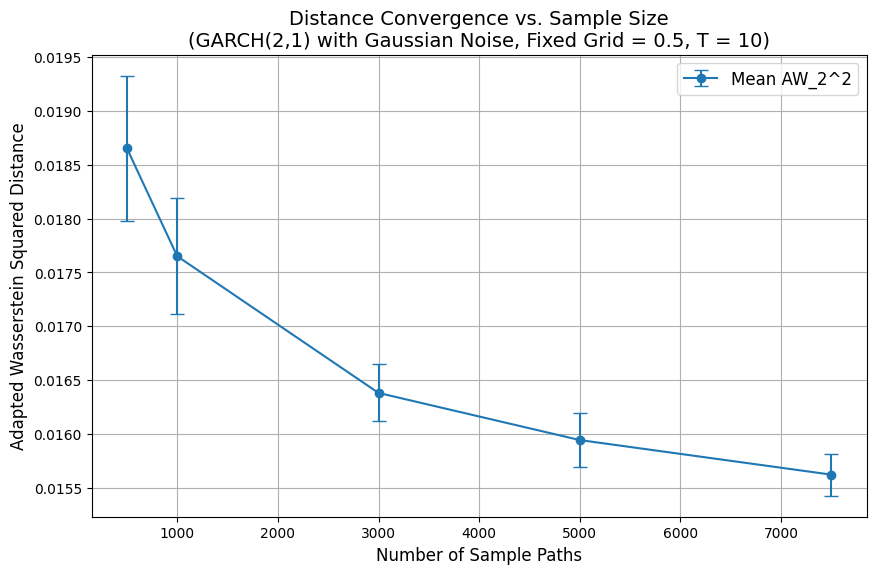

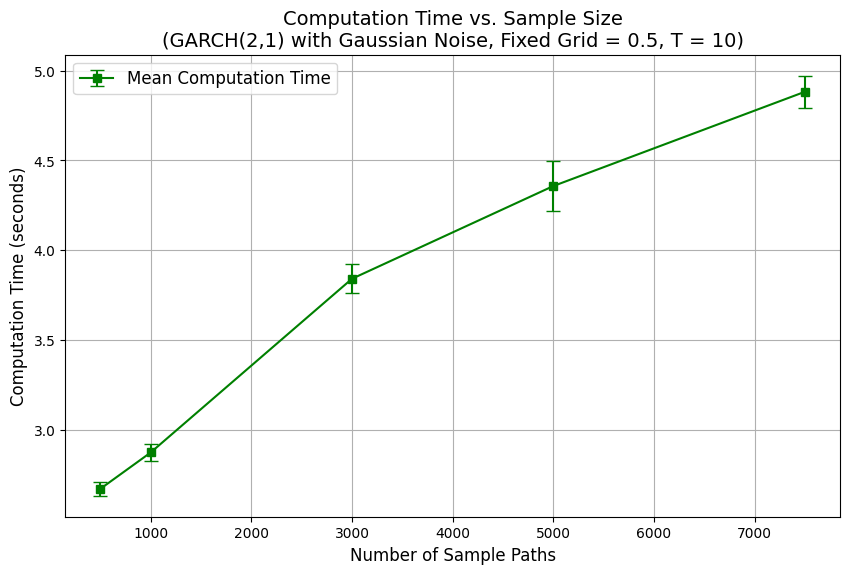

In [10]:
# ----------------------------------------------------------------------------
# Aggregating Results
# ----------------------------------------------------------------------------
sample_list = sorted(results.keys())
mean_distances = []
std_distances = []
mean_times = []
std_times = []

for n_sample in sample_list:
    data = results[n_sample]
    dists = data["distances"]
    times = data["times"]
    mean_distances.append(np.mean(dists))
    std_distances.append(np.std(dists))
    mean_times.append(np.mean(times))
    std_times.append(np.std(times))

# ----------------------------------------------------------------------------
# Plotting the Results
# ----------------------------------------------------------------------------

# Plot 1: Adapted Wasserstein Squared Distance vs. Sample Size
plt.figure(figsize=(10, 6))
plt.errorbar(sample_list, mean_distances, yerr=std_distances, fmt="o-", capsize=5, label="Mean AW_2^2")
plt.xlabel("Number of Sample Paths", fontsize=12)
plt.ylabel("Adapted Wasserstein Squared Distance", fontsize=12)
plt.title("Distance Convergence vs. Sample Size\n(GARCH(2,1) with Gaussian Noise, Fixed Grid = 0.5, T = 10)", fontsize=14)
plt.legend(fontsize=12)
plt.grid(True)
plt.show()

# Plot 2: Computation Time vs. Sample Size
plt.figure(figsize=(10, 6))
plt.errorbar(sample_list, mean_times, yerr=std_times, fmt="s-", capsize=5, color="green", label="Mean Computation Time")
plt.xlabel("Number of Sample Paths", fontsize=12)
plt.ylabel("Computation Time (seconds)", fontsize=12)
plt.title("Computation Time vs. Sample Size\n(GARCH(2,1) with Gaussian Noise, Fixed Grid = 0.5, T = 10)", fontsize=14)
plt.legend(fontsize=12)
plt.grid(True)
plt.show()